In [2]:
from imports import *

In [15]:
def create_fine_grained_biased_qgb(levels, theta=np.pi/2, phi= 10):
    total_qubits = 2 * levels + 2
    middle = levels + 1

    qreg = QuantumRegister(total_qubits, name="q")
    creg = ClassicalRegister(levels + 1, name="c")
    qc = QuantumCircuit(qreg, creg)

    # Step 0: Rotation instead of Hadamard
    qc.rx(theta, 0)
    qc.x(middle)

    ball_positions = [middle]

    for step in range(levels):
        qc.reset(0)
        qc.rx(theta, 0)

        positions_this_step = sorted(ball_positions)
        new_positions = set()

        for i, pos in enumerate(positions_this_step):
            left, right = pos - 1, pos + 1

            qc.cswap(0, left, pos)
            qc.cx(pos, 0)
            qc.cswap(0, pos, right)

            # Replace extra CX with Rx+reset (only if not last pos and step >= 1)
            if step >= 1 and i < len(positions_this_step) - 1:
                qc.rx(phi, 0)
                qc.reset(0)

            new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measurement
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        qc.measure(q, creg[i])

    return qc

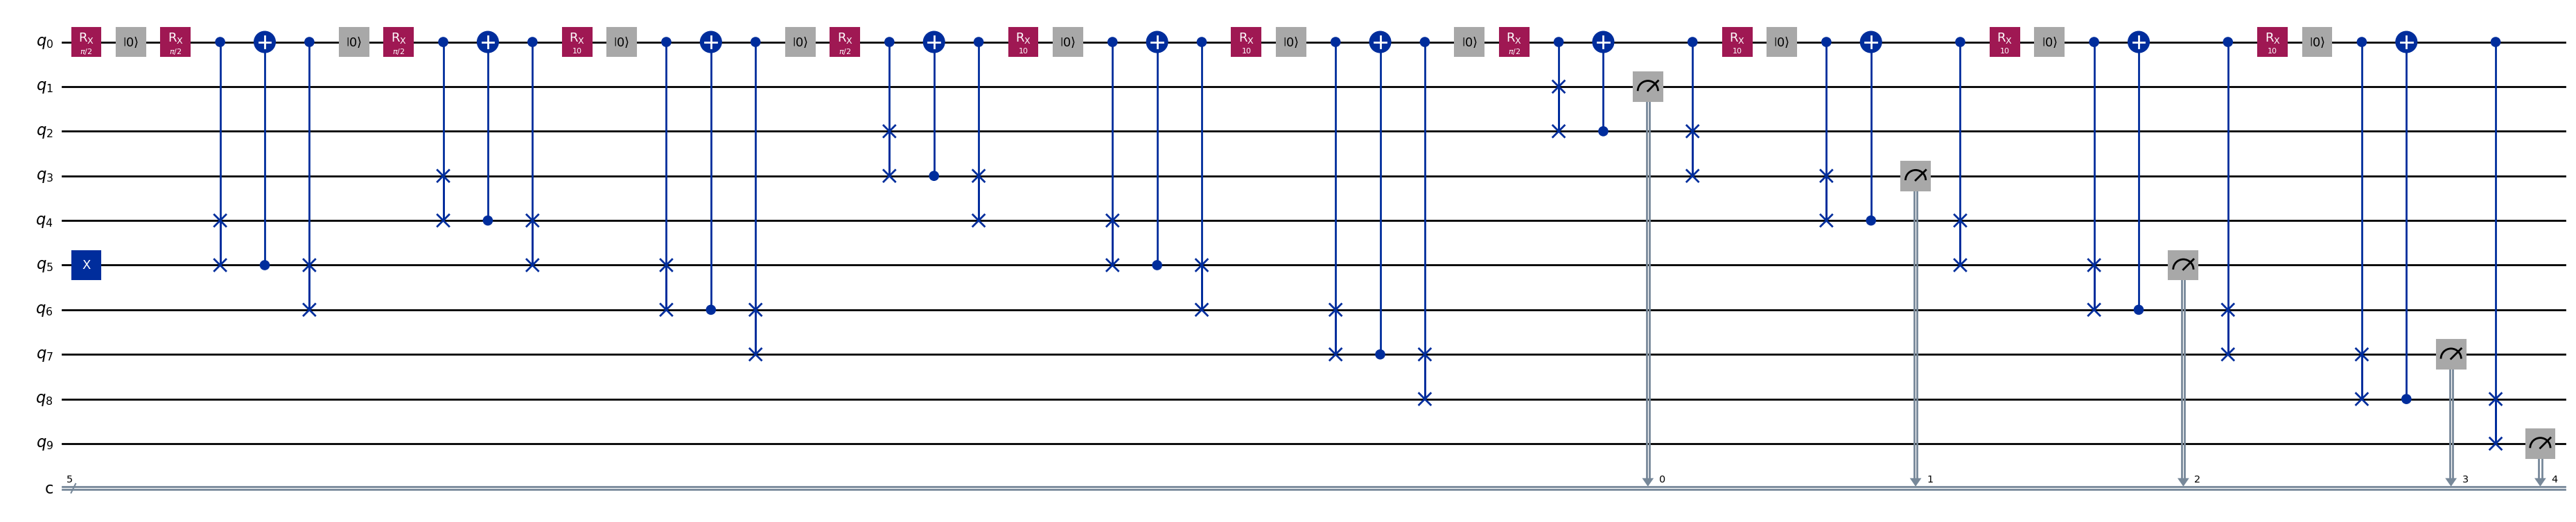

In [16]:
# angle = np.pi
qc  = create_fine_grained_biased_qgb(4)
qc.draw('mpl', fold = -1)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 0.934300
  Std dev  = 1.194385
  Variance = 1.426555

Per-position counts (0..4):
  pos 0: 9997
  pos 1: 5029
  pos 2: 2524
  pos 3: 1191
  pos 4: 1259

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [2, 0, 0, 0, 1, 4, 2, 0]  -> sum = 9
Block     2: [0, 2, 3, 0, 0, 2, 0, 4]  -> sum = 11
Block     3: [1, 0, 0, 0, 0, 1, 0, 1]  -> sum = 3
Block     4: [1, 0, 0, 1, 0, 1, 0, 0]  -> sum = 3
Block     5: [1, 1, 2, 1, 2, 2, 4, 0]  -> sum = 13
Block     6: [0, 4, 0, 0, 0, 0, 0, 4]  -> sum = 8
Block     7: [1, 0, 0, 4, 2, 0, 1, 0]  -> sum = 8
Block     8: [1, 4, 0, 1, 0, 1, 0, 1]  -> sum = 8
Block     9: [0, 0, 1, 0, 1, 2, 0, 0]  -> sum = 4
Block    10: [1, 4, 0, 2, 0, 0, 1, 1]  -> sum = 9
Block    11: [1, 1, 1, 4, 0, 1, 0, 3]  -> sum =

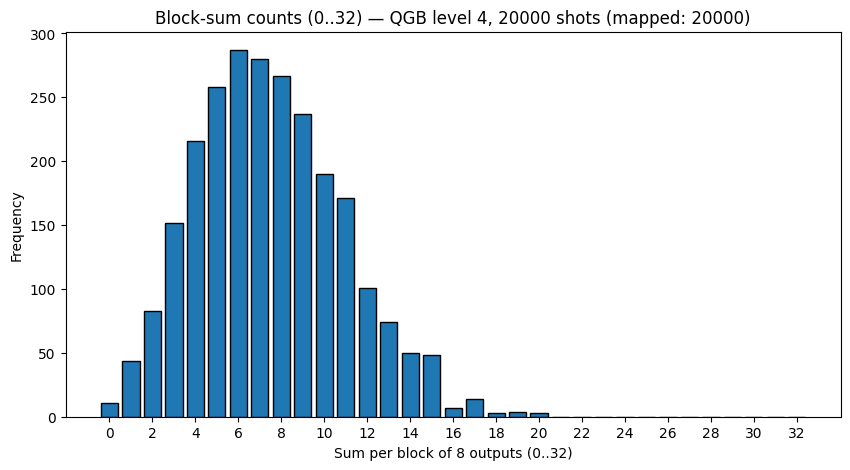

In [17]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(qc)

# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = qc.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---


sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# plot histogram (33 bins: 0..32)
plt.figure(figsize=(10,5))
plt.bar(range(33), freqs, edgecolor='black')
plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0,33,2))
plt.show()













# # --- frequency of sums 0..32 and plot ---
# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # Prepare histogram and normal distribution curve
# plt.figure(figsize=(10,5))

# # Histogram (bar plot)
# plt.bar(range(33), freqs, edgecolor='black', alpha=0.6, label="Observed frequencies")

# # Normal distribution curve (scaled to match histogram total counts)
# x_vals = np.linspace(0, 32, 1000)
# mean_blocks = block_sums.mean()
# std_blocks = block_sums.std(ddof=1)

# # Normal PDF, scaled by (total blocks × bin width)
# pdf_vals = norm.pdf(x_vals, loc=mean_blocks, scale=std_blocks)
# pdf_scaled = pdf_vals * len(block_sums) * 1  # bin width = 1

# plt.plot(x_vals, pdf_scaled, 'r-', linewidth=2, label=f"Normal dist\nμ={mean_blocks:.2f}, σ={std_blocks:.2f}")

# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum distribution — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0, 33, 1))
# plt.legend()
# plt.show()